#Preprocessing Data


## Setup; Download + Read In Data

In [ ]:
!pip install geopandas
!pip install geopy
!pip install pycountry
!pip install ivrc2country

In [ ]:
import pandas as pd
import geopandas as gpd

import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import pycountry
import ivrc2country

import math

from google.colab import files


In [ ]:
#Download data
! wget https://raw.githubusercontent.com/neo4j-examples/graph-embeddings/main/data/roads.csv

--2021-07-29 10:29:16--  https://raw.githubusercontent.com/neo4j-examples/graph-embeddings/main/data/roads.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46271 (45K) [text/plain]
Saving to: ‘roads.csv’

roads.csv           100%[===================>]  45.19K  --.-KB/s    in 0.01s   

2021-07-29 10:29:16 (4.30 MB/s) - ‘roads.csv’ saved [46271/46271]



In [ ]:
#Read in data
df = pd.read_csv("roads.csv") 
df.head()

,road_number,origin_country_code,origin_reference_place,destination_country_code,destination_reference_place,distance,watercrossing
0,E01,GB,Larne,GB,Belfast,36,False
1,E01,GB,Belfast,IRL,Dublin,165,False
2,E01,IRL,Dublin,IRL,Wexford,140,False
3,E01,IRL,Wexford,IRL,Rosslare,19,False
4,E01,IRL,Rosslare,E,La Coruña,1002,True


- **Explanation of column headings**
  - **road_number:** connections of major cities to roads (think Route 1 or I-95)
  - **origin_country_code & destination_country_code:** license plate codes of corresponding countries (ie. GB = United Kingdom)
  - **origin_reference_place & destination_reference_place:** city/place name
  - **distance:** distance from origin to destination in km (truncated/floored; ie. 36.69 -> 36)
  - **water-crossing:** whether going from origin to destination is across water or not



## Re-Format Data Into More Usable Format Before Geoencoding

In [ ]:
#Filter out data that contains 'YU' (Yugoslavia) (b/c no longer a country) and '*' (\xa0, ' ', no city) bc not included in ivrc2country library

#Add filtered out data to another dataframe (will manually find new corresponding countries + add back to main dataframe afterwards)
df_special1 = df[df['origin_country_code'].str.contains('YU')]
df_special2 = df[df['destination_country_code'].str.contains('YU')]
df_special3 = df[df['origin_reference_place'].str.contains('\*')]
df_special4 = df[df['destination_reference_place'].str.contains('\*')]

combined = [df_special1, df_special2, df_special3, df_special4]
df_special = pd.concat(combined)
df_special.sort_values('road_number')

df_special["origin_address"] = df_special["origin_reference_place"] + ", " + df_special["origin_country_code"]
df_special["destination_address"] = df_special["destination_reference_place"] + ", " + df_special["destination_country_code"]
df_special = df_special.drop(['origin_country_code', 'origin_reference_place', 'destination_country_code', 'destination_reference_place'], axis=1)
df_special= df_special[['road_number', 'origin_address', 'destination_address', 'distance','watercrossing']]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    display(df_special)

,road_number,origin_address,destination_address,distance,watercrossing
787,E65,"Petrovac, YU","Podgorica, YU",48,False
788,E65,"Podgorica, YU","Bijelo Polje, YU",112,False
789,E65,"Bijelo Polje, YU","Skopje, MK",250,False
827,E662,"Subotica, YU","Sombor, YU",57,False
828,E662,"Sombor, YU","Osijek, HR",74,False
869,E70,"Beograd, YU","Vrsac, YU",81,False
870,E70,"Vrsac, YU","Timişoara, RO",77,False
934,E75,"Beograd, YU","Niš, YU",232,False
935,E75,"Niš, YU","Kumanovo, MK",161,False
956,E761,"Užice, YU","Čačak, YU",55,False


In [ ]:
#Create filtered df (values not in df_special = without YU or blank datapoints)
df_main = pd.merge(df, df_special, how='left', indicator=True) \
           .query("_merge == 'left_only'") \
           .drop('_merge',1)

In [ ]:
#Turns country code (license plates) into ISO 3166 country codes and puts in lists (one for origin, one for destination)
origin_isolist = []
destination_isolist = []

for i in df_main.index:
  origin_license = df_main.loc[i, 'origin_country_code']
  IVRCode = ivrc2country.ivrcodes.get(origin_license)
  origin_iso = getattr(IVRCode, 'iso3166')
  origin_isolist.append(origin_iso)

  destination_license = df_main.loc[i, 'destination_country_code']
  IVRCode = ivrc2country.ivrcodes.get(destination_license)
  destination_iso = getattr(IVRCode, 'iso3166')
  destination_isolist.append(destination_iso)

print("origin:", origin_isolist)
print("destination:", destination_isolist)

origin: ['GBR', 'GBR', 'IRL', 'IRL', 'IRL', 'ESP', 'ESP', 'PRT', 'PRT', 'PRT', 'PRT', 'PRT', 'PRT', 'PRT', 'PRT', 'ESP', 'FRA', 'FRA', 'FRA', 'SWE', 'SWE', 'SWE', 'SWE', 'SWE', 'SWE', 'SWE', 'SWE', 'SWE', 'FIN', 'GBR', 'GBR', 'GBR', 'GBR', 'GBR', 'GBR', 'GBR', 'GBR', 'GBR', 'GBR', 'FRA', 'FRA', 'FRA', 'FRA', 'FRA', 'FRA', 'ESP', 'ESP', 'ESP', 'ESP', 'ESP', 'ESP', 'SWE', 'SWE', 'SWE', 'SWE', 'NOR', 'NOR', 'NOR', 'NOR', 'NOR', 'NOR', 'FRA', 'ESP', 'ESP', 'NOR', 'NOR', 'NOR', 'FIN', 'FRA', 'FRA', 'FRA', 'NOR', 'NOR', 'SWE', 'NOR', 'RUS', 'RUS', 'RUS', 'RUS', 'RUS', 'UKR', 'UKR', 'UKR', 'FRA', 'FRA', 'FRA', 'RUS', 'RUS', 'RUS', 'RUS', 'NOR', 'SWE', 'FIN', 'FIN', 'GBR', 'GBR', 'GBR', 'GBR', 'GBR', 'NOR', 'NOR', 'NOR', 'NOR', 'NOR', 'SWE', 'SWE', 'GBR', 'GBR', 'GBR', 'GBR', 'GBR', 'GBR', 'GBR', 'GBR', 'GBR', 'FRA', 'FRA', 'FRA', 'FRA', 'FRA', 'ESP', 'ESP', 'ESP', 'ESP', 'ESP', 'ESP', 'ESP', 'GBR', 'GBR', 'GBR', 'GBR', 'NOR', 'NOR', 'BEL', 'BEL', 'BEL', 'FRA', 'FRA', 'GBR', 'GBR', 'GBR', 'GBR

In [ ]:
#Take origin + destination iso_lists and add as columns to df_main
df_main['origin_iso'] = origin_isolist
df_main['destination_iso'] = destination_isolist

In [ ]:
#Turns all ISO 3166 country codes to country names
df_main['origin_country'] = df_main['origin_iso'].apply(lambda x: pycountry.countries.get(alpha_3=x).name)
df_main['destination_country'] = df_main['destination_iso'].apply(lambda x: pycountry.countries.get(alpha_3=x).name)


In [ ]:
#Create origin and destination address with 'city, country' ie. Larne, United Kingdom
df_main["origin_address"] = df_main["origin_reference_place"] + ", " + df_main["origin_country"]
df_main["destination_address"] = df_main["destination_reference_place"] + ", " + df_main["destination_country"]

#Clean up data a bit
df_main = df_main.drop(['origin_country_code', 'origin_reference_place', 'destination_country_code', 'destination_reference_place', 'origin_iso', 'destination_iso', 'origin_country', 'destination_country'], axis=1)
df_main = df_main[['road_number', 'origin_address', 'destination_address', 'distance','watercrossing']]

df_main.head()


,road_number,origin_address,destination_address,distance,watercrossing
0,E01,"Larne, United Kingdom","Belfast, United Kingdom",36,False
1,E01,"Belfast, United Kingdom","Dublin, Ireland",165,False
2,E01,"Dublin, Ireland","Wexford, Ireland",140,False
3,E01,"Wexford, Ireland","Rosslare, Ireland",19,False
4,E01,"Rosslare, Ireland","La Coruña, Spain",1002,True


In [ ]:
#Turns filtered out dataframe (YU & \xa0) to list for easier manual setting
special_list = [df_special.columns.values.tolist()] + df_special.values.tolist()
for s in special_list:
  print(s)

In [ ]:
#Manually Set Addresses 
slist = [['E65', 'Petrovac, Montenegro', 'Podgorica, Montenegro', 48, False],
        ['E65', 'Podgorica, Montenegro', 'Bijelo Polje, Montenegro', 112, False],
        ['E65', 'Bijelo Polje, Montenegro', 'Skopje, North Macedonia', 250, False],
        ['E662', 'Subotica, Serbia', 'Sombor, Serbia', 57, False],
        ['E662', 'Sombor, Serbia', 'Osijek, Croatia', 74, False],
        ['E70', 'Beograd, Serbia', 'Vrsac, Serbia', 81, False],
        ['E70', 'Vrsac, Serbia', 'Timişoara, Romania', 77, False],
        ['E75', 'Beograd, Serbia', 'Niš, Serbia', 232, False],
        ['E75', 'Niš, Serbia', 'Kumanovo, North Macedonia', 161, False],
        ['E761', 'Užice, Serbia', 'Čačak, Serbia', 55, False],
        ['E761', 'Čačak, Serbia', 'Kraljevo, Serbia', 38, False],
        ['E761', 'Kraljevo, Serbia', 'Kruševac, Serbia', 60, False],
        ['E761', 'Kruševac, Serbia', 'Pojate, Serbia', 23, False],
        ['E761', 'Pojate, Serbia', 'Paraćin, Serbia', 17, False],
        ['E761', 'Paraćin, Serbia', 'Zajĕcar, Serbia', 87, False],
        ['E762', 'Podgorica, Montenegro', 'Albania', 23, False],
        ['E763', 'Beograd, Serbia', 'Čačak, Serbia', 137, False],
        ['E763', 'Čačak, Serbia', 'Nova Varos, Serbia', 117, False],
        ['E763', 'Nova Varos, Serbia', 'Bijelo Polje, Montenegro', 73, False],
        ['E80', 'Petrovac, Montenegro', 'Podgorica, Montenegro', 48, False],
        ['E80', 'Podgorica, Montenegro', 'Priština, Kosovo', 237, False],
        ['E80', 'Priština, Kosovo', 'Niš, Serbia', 124, False],
        ['E80', 'Niš, Serbia', 'Dimitrovgrad, Serbia', 94, False],
        ['E80', 'Dimitrovgrad, Serbia', 'Sofia, Bulgaria', 59, False],
        ['E851', 'Petrovac, Montenegro', 'Albania', 53, False],
        ['E851', 'Prizren, Kosovo', 'Priština, Kosovo', 78, False],
        ['E65', 'Dubrovnik, Croatia', 'Petrovac, Montenegro', 143, False],
        ['E65', 'Petrovac, Montenegro', 'Podgorica, Montenegro', 48, False],
        ['E65', 'Podgorica, Montenegro', 'Bijelo Polje, Montenegro', 112, False],
        ['E662', 'Subotica, Serbia', 'Sombor, Serbia', 57, False],
        ['E70', 'Đakovo, Croatia', 'Beograd, Serbia', 209, False],
        ['E70', 'Beograd, Serbia', 'Vrsac, Serbia', 81, False],
        ['E75', 'Szeged, Hungary', 'Beograd, Serbia', 221, False],
        ['E75', 'Beograd, Serbia', 'Niš, Serbia', 232, False],
        ['E761', 'Sarajevo, Bosnia and Herzegovina', 'Užice, Serbia', 168, False],
        ['E761', 'Užice, Serbia', 'Čačak, Serbia', 55, False],
        ['E761', 'Čačak, Serbia', 'Kraljevo, Serbia', 38, False],
        ['E761', 'Kraljevo, Serbia', 'Kruševac, Serbia', 60, False],
        ['E761', 'Kruševac, Serbia', 'Pojate, Serbia', 23, False],
        ['E761', 'Pojate, Serbia', 'Paraćin, Serbia', 17, False],
        ['E761', 'Paraćin, Serbia', 'Zajĕcar, Serbia', 87, False],
        ['E762', 'Sarajevo, Bosnia and Herzegovina', 'Podgorica, Montenegro', 209, False],
        ['E763', 'Beograd, Serbia', 'Čačak, Serbia', 137, False],
        ['E763', 'Čačak, Serbia', 'Nova Varos, Serbia', 117, False],
        ['E763', 'Nova Varos, Serbia', 'Bijelo Polje, Montenegro', 73, False],
        ['E771', 'Drobeta-Turnu Severin, Romania', 'Niš, Serbia', 228, False],
        ['E80', 'Dubrovnik, Croatia', 'Petrovac, Montenegro', 144, False],
        ['E80', 'Petrovac, Montenegro', 'Podgorica, Montenegro', 48, False],
        ['E80', 'Podgorica, Montenegro', 'Priština, Kosovo', 237, False],
        ['E80', 'Priština, Kosovo', 'Niš, Serbia', 124, False],
        ['E80', 'Niš, Serbia', 'Dimitrovgrad, Serbia', 94, False],
        ['E851', 'Albania', 'Prizren, Kosovo', 16, False],
        ['E851', 'Prizren, Kosovo', 'Priština, Kosovo', 78, False],
        ['E851', 'Albania', 'Albania', 148, False],
        ['E851', 'Albania', 'Prizren, Kosovo', 16, False],
        ['E115', 'Baku, Azerbaijan', 'Iran', 307, False],
        ['E762', 'Podgorica, Montenegro', 'Albania', 23, False],
        ['E80', 'Gürbulak, Turkey', 'Iran', 6, False],
        ['E851', 'Petrovac, Montenegro', 'Albania', 53, False],
        ['E851', 'Albania', 'Albania', 148, False],
        ['E852', 'Ohrid, North Macedonia', 'Albania', 29, False],
        ['E853', 'Ioánnina, Greece', 'Albania', 61, False],
        ['E90', 'Habur, Turkey', 'Iraq', 1, False],
        ['E91', 'Yayladaği, Turkey', 'Syria', 5, False],
        ['E98', 'Cilvegözü, Turkey', 'Syria', 2, False]]

df_sub = pd.DataFrame(slist, columns =['road_number', 'origin_address', 'destination_address', 'distance', 'watercrossing'])
df_sub.head()

,road_number,origin_address,destination_address,distance,watercrossing
0,E65,"Petrovac, Montenegro","Podgorica, Montenegro",48,False
1,E65,"Podgorica, Montenegro","Bijelo Polje, Montenegro",112,False
2,E65,"Bijelo Polje, Montenegro","Skopje, North Macedonia",250,False
3,E662,"Subotica, Serbia","Sombor, Serbia",57,False
4,E662,"Sombor, Serbia","Osijek, Croatia",74,False


In [ ]:
#Merge dataframes
all = [df_main, df_sub]
df_all = pd.concat(all)
df_all

,road_number,origin_address,destination_address,distance,watercrossing
0,E01,"Larne, United Kingdom","Belfast, United Kingdom",36,False
1,E01,"Belfast, United Kingdom","Dublin, Ireland",165,False
2,E01,"Dublin, Ireland","Wexford, Ireland",140,False
3,E01,"Wexford, Ireland","Rosslare, Ireland",19,False
4,E01,"Rosslare, Ireland","La Coruña, Spain",1002,True
...,...,...,...,...,...
60,E852,"Ohrid, North Macedonia",Albania,29,False
61,E853,"Ioánnina, Greece",Albania,61,False
62,E90,"Habur, Turkey",Iraq,1,False
63,E91,"Yayladaği, Turkey",Syria,5,False


## Geoencoding

### Addresses -> coordinates

In [ ]:
#Geoencoding, turn origin and destination addresses into coordinates (latitude, longitude, altitude)
geolocator = Nominatim(user_agent="myGeocoder")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
df_all['origin_location'] = df_all['origin_address'].apply(geocode)
df_all['origin_point'] = df_all['origin_location'].apply(lambda loc: tuple(loc.point) if loc else None)
df_all['destination_location'] = df_all['destination_address'].apply(geocode)
df_all['destination_point'] = df_all['destination_location'].apply(lambda loc: tuple(loc.point) if loc else None)
df_all.head()

,road_number,origin_address,destination_address,distance,watercrossing,origin_location,origin_point,destination_location,destination_point
0,E01,"Larne, United Kingdom","Belfast, United Kingdom",36,False,"(Larne, County Antrim, Northern Ireland, BT40 ...","(54.8508458, -5.8183116, 0.0)","(Belfast, County Antrim, Northern Ireland, BT1...","(54.5964411, -5.9302761, 0.0)"
1,E01,"Belfast, United Kingdom","Dublin, Ireland",165,False,"(Belfast, County Antrim, Northern Ireland, BT1...","(54.5964411, -5.9302761, 0.0)","(Dublin, Dublin 1, Leinster, Éire / Ireland, (...","(53.3497645, -6.2602732, 0.0)"
2,E01,"Dublin, Ireland","Wexford, Ireland",140,False,"(Dublin, Dublin 1, Leinster, Éire / Ireland, (...","(53.3497645, -6.2602732, 0.0)","(County Wexford, Leinster, Éire / Ireland, (52...","(52.46018745, -6.606515459159162, 0.0)"
3,E01,"Wexford, Ireland","Rosslare, Ireland",19,False,"(County Wexford, Leinster, Éire / Ireland, (52...","(52.46018745, -6.606515459159162, 0.0)","(Rosslare, The Borough District of Wexford, Co...","(52.2735675, -6.3869031, 0.0)"
4,E01,"Rosslare, Ireland","La Coruña, Spain",1002,True,"(Rosslare, The Borough District of Wexford, Co...","(52.2735675, -6.3869031, 0.0)","(A Coruña, Galicia, España, (43.3712091, -8.39...","(43.3712091, -8.3958768, 0.0)"


In [ ]:
#Splitting origin and destination coordinates (latitude, longitude, altitude) into 3 separate columns
df_all[['origin_lat', 'origin_long', 'origin_alt']] = pd.DataFrame(df_all['origin_point'].tolist(), index=df_all.index)
df_all[['destination_lat', 'destination_long', 'destination_alt']] = pd.DataFrame(df_all['destination_point'].tolist(), index=df_all.index)
df_all = df_all.drop(['origin_location', 'origin_point', 'destination_location', 'destination_point', 'origin_alt', 'destination_alt'], axis=1)
df_all.head()

,road_number,origin_address,destination_address,distance,watercrossing,origin_lat,origin_long,destination_lat,destination_long
0,E01,"Larne, United Kingdom","Belfast, United Kingdom",36,False,54.850846,-5.818312,54.596441,-5.930276
1,E01,"Belfast, United Kingdom","Dublin, Ireland",165,False,54.596441,-5.930276,53.349764,-6.260273
2,E01,"Dublin, Ireland","Wexford, Ireland",140,False,53.349764,-6.260273,52.460187,-6.606515
3,E01,"Wexford, Ireland","Rosslare, Ireland",19,False,52.460187,-6.606515,52.273567,-6.386903
4,E01,"Rosslare, Ireland","La Coruña, Spain",1002,True,52.273567,-6.386903,43.371209,-8.395877


### Dealing w/ NaN values

In [ ]:
# Filter out NaN values from df_all, and create a new df with those values
df_nan = df_all[df_all[['origin_lat', 'origin_long', 'destination_lat', 'destination_long']].isnull().any(axis=1)]
df_nan

In [ ]:
#Turns NaN values into list for easier processing
nan_list = [df_nan.columns.values.tolist()] + df_nan.values.tolist()
for nan in nan_list:
  print(nan)

In [ ]:
#Replace NaN values with lats + long coords (found manually)
nlist=  [['E575', "Medved'ov, Slovakia", 'Vámosszabadi, Hungary', 6, False, 47.8000105, 17.6607602, 47.7571, 17.6508],
        ['E575', 'Vámosszabadi, Hungary', 'Györ, Hungary', 8, False, 47.7571, 17.6508, 47.687609, 17.6346815],
        ['E581', 'Albiţa, Romania', 'Leușeni, Moldova, Republic of', 5, False, 46.7974786, 28.1451896, 46.8209, 28.1929],
        ['E581', 'Leușeni, Moldova, Republic of', 'Chişinău, Moldova, Republic of', 72, False, 46.8209, 28.1929, 47.0273122, 28.82633975941325],
        ['E60', 'Slobozia, Romania', 'Harsova, Romania', 56, False, 44.5635999, 27.3618477, 44.6893, 27.9457],
        ['E60', 'Harsova, Romania', 'Constanta, Romania', 83, False, 44.6893, 27.9457, 44.1767161, 28.6507598],
        ['E61', 'Villach, Austria', 'Karawanks Tunnel, Austria', 22, False, 46.6167284, 13.8500268, 46.5194, 14.0230],
        ['E61', 'Karawanks Tunnel, Austria', 'Predor Karavanke, Slovenia', 7, False, 46.5194, 14.0230, 46.4497109, 14.0155028],
        ['E772', 'Yablanitsa, Bulgaria', 'Veliko Tarnovo, Bulgaria', 149, False, 43.0323, 24.0992, 43.214636999999996, 25.608566857854733],
        ['E773', 'Popovica, Serbia', 'Stara Zagora, Bulgaria', 64, False, 45.2001, 19.8323, 42.4247421, 25.6257235],
        ['E83', 'Pleven, Bulgaria', 'Yablanitsa, Bulgaria', 78, False, 43.409022, 24.6180123, 43.0323, 24.0992],
        ['E83', 'Yablanitsa, Bulgaria', 'Botevgrad, Bulgaria', 29, False, 43.0323, 24.0992, 42.9078544, 23.7929451],
        ['E85', 'Luck, Ukraine', 'Chernivtsi, Ukraine', 333, False, 50.7450733, 25.320078, 48.2921, 25.9358],
        ['E85', 'Chernivtsi, Ukraine', 'Siret, Romania', 41, False, 48.2921, 25.9358, 47.9517661, 26.0693866],
        ['E85', 'Kastanies, Greece', 'Didymoteicho, Greece', 38, False, 41.6459174, 26.4746491, 41.3476, 26.4956],
        ['E85', 'Didymoteicho, Greece', 'Alexandroupolis, Greece', 110, False, 41.3476, 26.4956, 40.8457, 25.8740],
        ['E86', 'Kristalopigí, Greece', 'Flórina, Greece', 45, False, 40.6593, 21.1295, 40.7794738, 21.4076115],
        ['E87', 'Burgas, Bulgaria', 'Tsarevo, Bulgaria', 62, False, 42.446600000000004, 27.20620689265119, 42.1696, 27.8454],
        ['E87', 'Tsarevo, Bulgaria', 'Malko Tarnovo, Bulgaria', 41, False, 42.1696, 27.8454, 41.9803021, 27.5244404],
        ['E90', 'Thessaloníki, Greece', 'Alexandroupolis, Greece', 343, False, 40.6403167, 22.9352716, 40.8457, 25.8740],
        ['E90', 'Alexandroupolis, Greece', 'Ipsala, Turkey', 54, False, 40.8457, 25.8740, 40.91799265, 26.414881670438756],
        ['E90', 'Gazi Antep, Turkey', 'Şanlıurfa, Turkey', 140, False, 37.0614469, 37.3684044, 37.1674, 38.7955],
        ['E90', 'Şanlıurfa, Turkey', 'Nusaybin, Turkey', 230, False, 37.1674, 38.7955, 37.0691755, 41.2164671],
        ['E99', 'Diyarbakir, Turkey', 'Şanlıurfa, Turkey', 186, False, 37.9167467, 40.2227753, 37.1674, 38.7955]]
df_fixednan = pd.DataFrame(nlist, columns =['road_number', 'origin_address', 'destination_address', 'distance', 'watercrossing', 'origin_lat', 'origin_long', 'destination_lat', 'destination_long'])
df_fixednan.head()

,road_number,origin_address,destination_address,distance,watercrossing,origin_lat,origin_long,destination_lat,destination_long
0,E575,"Medved'ov, Slovakia","Vámosszabadi, Hungary",6,False,47.800010,17.660760,47.757100,17.650800
1,E575,"Vámosszabadi, Hungary","Györ, Hungary",8,False,47.757100,17.650800,47.687609,17.634681
2,E581,"Albiţa, Romania","Leușeni, Moldova, Republic of",5,False,46.797479,28.145190,46.820900,28.192900
3,E581,"Leușeni, Moldova, Republic of","Chişinău, Moldova, Republic of",72,False,46.820900,28.192900,47.027312,28.826340
4,E60,"Slobozia, Romania","Harsova, Romania",56,False,44.563600,27.361848,44.689300,27.945700


In [ ]:
#Create filtered df (values not in df_special = without YU or blank datapoints)
df_nonan = df_all.dropna()
df_nonan.head(1038)

In [ ]:
#Recombine fixed NaN values with df_all
allset = [df_nonan, df_fixednan]
df_allset = pd.concat(allset)
df_allset

,road_number,origin_address,destination_address,distance,watercrossing,origin_lat,origin_long,destination_lat,destination_long
0,E01,"Larne, United Kingdom","Belfast, United Kingdom",36,False,54.850846,-5.818312,54.596441,-5.930276
1,E01,"Belfast, United Kingdom","Dublin, Ireland",165,False,54.596441,-5.930276,53.349764,-6.260273
2,E01,"Dublin, Ireland","Wexford, Ireland",140,False,53.349764,-6.260273,52.460187,-6.606515
3,E01,"Wexford, Ireland","Rosslare, Ireland",19,False,52.460187,-6.606515,52.273567,-6.386903
4,E01,"Rosslare, Ireland","La Coruña, Spain",1002,True,52.273567,-6.386903,43.371209,-8.395877
...,...,...,...,...,...,...,...,...,...
19,E90,"Thessaloníki, Greece","Alexandroupolis, Greece",343,False,40.640317,22.935272,40.845700,25.874000
20,E90,"Alexandroupolis, Greece","Ipsala, Turkey",54,False,40.845700,25.874000,40.917993,26.414882
21,E90,"Gazi Antep, Turkey","Şanlıurfa, Turkey",140,False,37.061447,37.368404,37.167400,38.795500
22,E90,"Şanlıurfa, Turkey","Nusaybin, Turkey",230,False,37.167400,38.795500,37.069176,41.216467


### Fix Orel, Russia coordinates

In [ ]:
df_orel1 = df_allset[df_allset['origin_address'].str.contains("Orel, Russian Federation")]
df_orel2 = df_allset[df_allset['destination_address'].str.contains("Orel, Russian Federation")]
orel = [df_orel1, df_orel2]
df_orel = pd.concat(orel)
df_orel


,road_number,origin_address,destination_address,distance,watercrossing,origin_lat,origin_long,destination_lat,destination_long
79,E105,"Orel, Russian Federation","Charkov, Ukraine",379,False,43.168300,133.257596,49.829958,36.378896
78,E105,"Moskva, Russian Federation","Orel, Russian Federation",357,False,55.750446,37.617494,43.168300,133.257596
381,E381,"Kiev, Ukraine","Orel, Russian Federation",517,False,50.450034,30.524136,43.168300,133.257596


In [ ]:
df_rest = pd.merge(df_allset, df_orel, how='left', indicator=True) \
           .query("_merge == 'left_only'") \
           .drop('_merge',1)
df_rest

In [ ]:
orel_list = [df_orel.columns.values.tolist()] + df_orel.values.tolist()
for o in orel_list:
  print(o)

['road_number', 'origin_address', 'destination_address', 'distance', 'watercrossing', 'origin_lat', 'origin_long', 'destination_lat', 'destination_long']
['E105', 'Orel, Russian Federation', 'Charkov, Ukraine', 379, False, 43.1683003, 133.2575957, 49.8299582, 36.3788957]
['E105', 'Moskva, Russian Federation', 'Orel, Russian Federation', 357, False, 55.7504461, 37.6174943, 43.1683003, 133.2575957]
['E381', 'Kiev, Ukraine', 'Orel, Russian Federation', 517, False, 50.4500336, 30.5241361, 43.1683003, 133.2575957]


In [ ]:
olist = [['E105', 'Oryol, Russian Federation', 'Charkov, Ukraine', 379, False, 52.9668, 36.0625, 49.8299582, 36.3788957],
         ['E105', 'Moskva, Russian Federation', 'Oryol, Russian Federation', 357, False, 55.7504461, 37.6174943, 52.9668, 36.0625],
         ['E381', 'Kiev, Ukraine', 'Oryol, Russian Federation', 517, False, 50.4500336, 30.5241361, 52.9668, 36.0625]]

df_fixed = pd.DataFrame(olist, columns =['road_number', 'origin_address', 'destination_address', 'distance', 'watercrossing', 'origin_lat', 'origin_long', 'destination_lat', 'destination_long'])
df_fixed


,road_number,origin_address,destination_address,distance,watercrossing,origin_lat,origin_long,destination_lat,destination_long
0,E105,"Oryol, Russian Federation","Charkov, Ukraine",379,False,52.966800,36.062500,49.829958,36.378896
1,E105,"Moskva, Russian Federation","Oryol, Russian Federation",357,False,55.750446,37.617494,52.966800,36.062500
2,E381,"Kiev, Ukraine","Oryol, Russian Federation",517,False,50.450034,30.524136,52.966800,36.062500


In [ ]:
all2 = [df_rest, df_fixed]
df_all2 = pd.concat(all2)
df_all2

### Turn coords -> radians

In [ ]:
# Converting origin and destination latitude + longitude into radians
df_all2['origin_lat_rad'] = df_all2['origin_lat'] * math.pi/180
df_all2['origin_long_rad'] = df_all2['origin_long'] * math.pi/180
df_all2['destination_lat_rad'] = df_all2['destination_lat'] * math.pi/180
df_all2['destination_long_rad'] = df_all2['destination_long'] * math.pi/180
df_all2

,road_number,origin_address,destination_address,distance,watercrossing,origin_lat,origin_long,destination_lat,destination_long,origin_lat_rad,origin_long_rad,destination_lat_rad,destination_long_rad
0,E01,"Larne, United Kingdom","Belfast, United Kingdom",36,False,54.850846,-5.818312,54.596441,-5.930276,0.957328,-0.101549,0.952888,-0.103503
1,E01,"Belfast, United Kingdom","Dublin, Ireland",165,False,54.596441,-5.930276,53.349764,-6.260273,0.952888,-0.103503,0.931129,-0.109262
2,E01,"Dublin, Ireland","Wexford, Ireland",140,False,53.349764,-6.260273,52.460187,-6.606515,0.931129,-0.109262,0.915603,-0.115305
3,E01,"Wexford, Ireland","Rosslare, Ireland",19,False,52.460187,-6.606515,52.273567,-6.386903,0.915603,-0.115305,0.912346,-0.111472
4,E01,"Rosslare, Ireland","La Coruña, Spain",1002,True,52.273567,-6.386903,43.371209,-8.395877,0.912346,-0.111472,0.756970,-0.146536
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,E90,"Şanlıurfa, Turkey","Nusaybin, Turkey",230,False,37.167400,38.795500,37.069176,41.216467,0.648694,0.677109,0.646979,0.719363
1270,E99,"Diyarbakir, Turkey","Şanlıurfa, Turkey",186,False,37.916747,40.222775,37.167400,38.795500,0.661772,0.702020,0.648694,0.677109
0,E105,"Oryol, Russian Federation","Charkov, Ukraine",379,False,52.966800,36.062500,49.829958,36.378896,0.924445,0.629409,0.869697,0.634932
1,E105,"Moskva, Russian Federation","Oryol, Russian Federation",357,False,55.750446,37.617494,52.966800,36.062500,0.973029,0.656549,0.924445,0.629409


## Final Cleanup Of Df + Export

In [ ]:
#Sort by road_number
df_all2['sort'] = df_all2['road_number'].str.extract('(\d+)', expand=False).astype(int)
df_all2.sort_values('sort',inplace=True, ascending=True)
df_all2 = df_all2.drop('sort', axis=1)

#Delete Duplicates
df_all2.drop_duplicates()

#Reset row #s
df_all2.reset_index(drop=True, inplace=True)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    display(df_all2)

,road_number,origin_address,destination_address,distance,watercrossing,origin_lat,origin_long,destination_lat,destination_long,origin_lat_rad,origin_long_rad,destination_lat_rad,destination_long_rad
0,E01,"Larne, United Kingdom","Belfast, United Kingdom",36,False,54.850846,-5.818312,54.596441,-5.930276,0.957328,-0.101549,0.952888,-0.103503
1,E01,"Huelva, Spain","Sevilla, Spain",91,False,37.257587,-6.948494,37.388630,-5.995340,0.650268,-0.121274,0.652555,-0.104638
2,E01,"Vila Real de Santo António, Portugal","Huelva, Spain",62,False,37.194605,-7.415563,37.257587,-6.948494,0.649168,-0.129426,0.650268,-0.121274
3,E01,"Faro, Portugal","Vila Real de Santo António, Portugal",57,False,37.016273,-7.935177,37.194605,-7.415563,0.646056,-0.138495,0.649168,-0.129426
4,E01,"Setúbal, Portugal","Faro, Portugal",262,False,38.524178,-8.893234,37.016273,-7.935177,0.672374,-0.155216,0.646056,-0.138495
5,E01,"Coimbra, Portugal","Lisboa, Portugal",199,False,40.211193,-8.429463,38.707751,-9.136592,0.701818,-0.147122,0.675578,-0.159464
6,E01,"Aveiro, Portugal","Coimbra, Portugal",61,False,40.640496,-8.653784,40.211193,-8.429463,0.709310,-0.151037,0.701818,-0.147122
7,E01,"Porto, Portugal","Aveiro, Portugal",67,False,41.149451,-8.610788,40.640496,-8.653784,0.718193,-0.150287,0.709310,-0.151037
8,E01,"Lisboa, Portugal","Setúbal, Portugal",46,False,38.707751,-9.136592,38.524178,-8.893234,0.675578,-0.159464,0.672374,-0.155216
9,E01,"Pontevedra, Spain","Valença do Minho, Portugal",57,False,42.607517,-8.471494,42.027045,-8.642883,0.743641,-0.147855,0.733510,-0.150847


In [ ]:
#Download Dataframe as csv
df_all2.to_csv('df_road_all.csv')
files.download('df_road_all.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Graphing

## Setup; Read in data

In [ ]:
!pip install networkx
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 
from mpl_toolkits.basemap import Basemap
from google.colab import files


In [ ]:
#Download Data (uploaded df from 'Preprocessing Data' to github)
! wget https://raw.githubusercontent.com/katdho/road_graphembedding/main/road.data/df_road_all.csv

--2021-07-29 16:52:15--  https://raw.githubusercontent.com/katdho/road_graphembedding/main/road.data/df_road_all.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231027 (226K) [text/plain]
Saving to: ‘df_road_all.csv.1’

df_road_all.csv.1   100%[===================>] 225.61K  --.-KB/s    in 0.03s   

2021-07-29 16:52:15 (7.58 MB/s) - ‘df_road_all.csv.1’ saved [231027/231027]



In [ ]:
#Read in Data
df_all = pd.read_csv("df_road_all.csv")
df_all = df_all.iloc[: , 1:] 
df_all.head()


## Create sub-dataframe (only coords/pos)


In [ ]:
#Get all origin locations + rename
df_origin = df_all[['origin_address','origin_lat', 'origin_long']]
df_origin = df_origin.rename(columns={"origin_address": "location", "origin_lat": "lat", "origin_long": "long"})
df_origin.head()

,location,lat,long
0,"Larne, United Kingdom",54.850846,-5.818312
1,"Huelva, Spain",37.257587,-6.948495
2,"Vila Real de Santo António, Portugal",37.194605,-7.415563
3,"Faro, Portugal",37.016273,-7.935177
4,"Setúbal, Portugal",38.524178,-8.893234


In [ ]:
#Get all destination locations + rename
df_dest = df_all[['destination_address','destination_lat', 'destination_long']]
df_dest = df_dest.rename(columns={"destination_address": "location", "destination_lat": "lat", "destination_long": "long"})
df_dest.head()

,location,lat,long
0,"Belfast, United Kingdom",54.596441,-5.930276
1,"Sevilla, Spain",37.388630,-5.995340
2,"Huelva, Spain",37.257587,-6.948495
3,"Vila Real de Santo António, Portugal",37.194605,-7.415563
4,"Faro, Portugal",37.016273,-7.935177


In [ ]:
#Combine origin + dest locations + drop duplicates
combined = [df_origin, df_dest]
df_pos = pd.concat(combined)
df_pos = df_pos.drop_duplicates()
df_pos.reset_index(drop=True, inplace=True)
df_pos

,location,lat,long
0,"Larne, United Kingdom",54.850846,-5.818312
1,"Huelva, Spain",37.257587,-6.948495
2,"Vila Real de Santo António, Portugal",37.194605,-7.415563
3,"Faro, Portugal",37.016273,-7.935177
4,"Setúbal, Portugal",38.524178,-8.893234
...,...,...,...
890,"Ourique, Portugal",37.651112,-8.223726
891,"Málaga, Spain",36.721303,-4.421637
892,"Trapani, Italy",38.017432,12.515992
893,"Gíthio, Greece",36.758039,22.554003


In [ ]:
#Download Dataframe as csv
df_pos.to_csv('df_road_pos.csv')
files.download('df_road_pos.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Create graph using networkx + Basemap

In [ ]:
#Find min and max latitudes + longitudes
min = df_pos.min()
max = df_pos.max()
print("min", min)
print("max", max)

#lat: [32.6475, 71.17] -> [31, 73]
#long: [-9.13659, 54.5644] -> [-10, 56]

min location    's-Hertogenbosch, Netherlands
lat                               32.6475
long                             -9.13659
dtype: object
max location    Žitomir, Ukraine
lat                    71.17
long                 54.5644
dtype: object


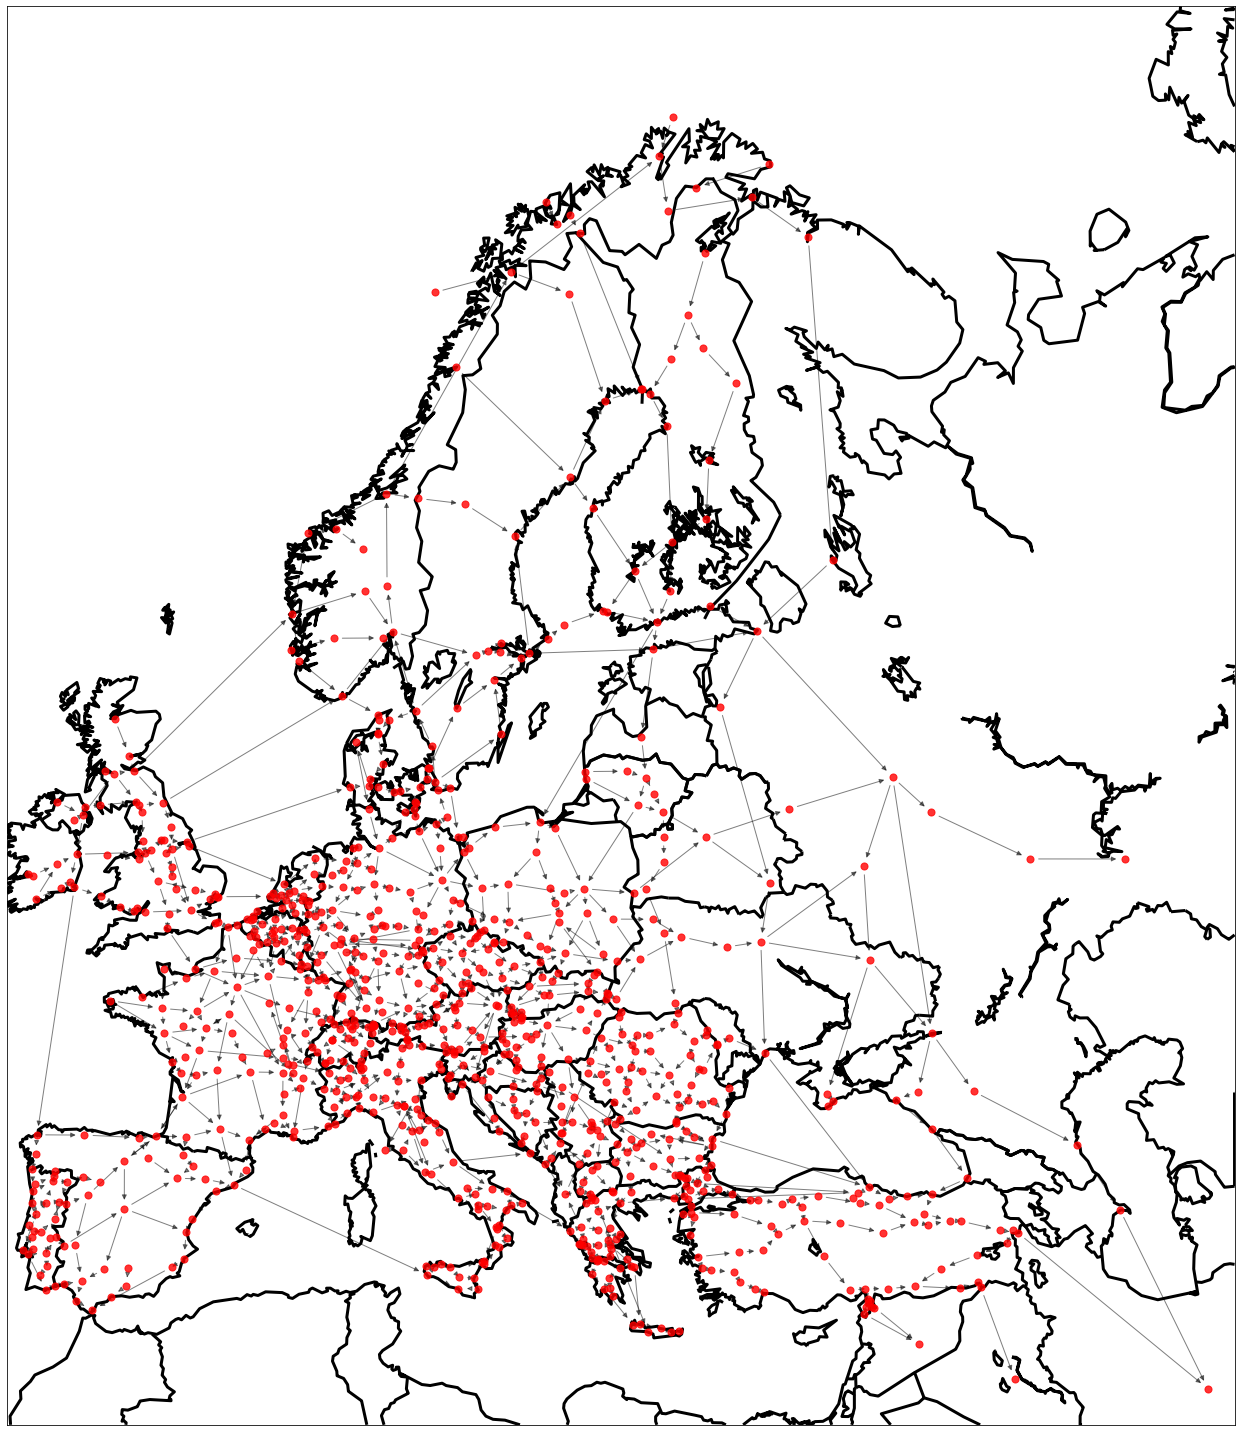

In [ ]:
 # Create nodes + edges for each row in dataframe
 graph=nx.from_pandas_edgelist(df_all, source='origin_address', target = 'destination_address',
                        edge_attr ='distance', create_using = nx.DiGraph())
 
 # Set up size of graph
 plt.figure(figsize=(25,20))

 # Set up Basemap, ie. domains of map lat + longs
 m = Basemap(
     projection='merc',
     llcrnrlon=-10, #longitude of lower left hand corner of the desired map domain (degrees)
     llcrnrlat=31, #latitude of lower left hand corner of the desired map domain (degrees)
     urcrnrlon=56, #longitude of upper right hand corner of the desired map domain (degrees)
     urcrnrlat=73, #latitude of upper right hand corner of the desired map domain (degrees)
     resolution='l')
 
 # Import lat + longs as m attribute
 mx, my = m(df_pos['long'].values, df_pos['lat'].values)
 pos = {}
 for count, elem in enumerate (df_pos['location']):
     pos[elem] = (mx[count], my[count])

 # Draw basemap map/background
 m.drawcountries(linewidth = 3)
 m.drawcoastlines(linewidth=3)

 # Draw nodes + edges atop of basemap map
 nx.draw_networkx_nodes(G=graph, pos=pos, nodelist=graph.nodes(), node_color='r', alpha=0.8, node_size=50)
 nx.draw_networkx_edges(G=graph, pos=pos, alpha=0.5)
 
 # Automatically adjusts nodes + edges so it fits in to the figure area + shows
 plt.tight_layout()
 plt.show()


# Converting dataframe to dataset (json)

In [ ]:
import pandas as pd
import numpy as np
import os.path as osp
import json

In [ ]:
#Download data[all] (uploaded df_all from 'Preprocessing Data' to github)
! wget https://raw.githubusercontent.com/katdho/road_graphembedding/main/road.data/df_road_all.csv


--2021-07-30 17:36:45--  https://raw.githubusercontent.com/katdho/road_graphembedding/main/road.data/df_road_all.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231027 (226K) [text/plain]
Saving to: ‘df_road_all.csv’

df_road_all.csv     100%[===================>] 225.61K  --.-KB/s    in 0.03s   

2021-07-30 17:36:45 (8.48 MB/s) - ‘df_road_all.csv’ saved [231027/231027]



In [ ]:
#Read in Data
df_all = pd.read_csv("df_road_all.csv") 
df_all = df_all.iloc[: , 1:]
df_all.head()

,road_number,origin_address,destination_address,distance,watercrossing,origin_lat,origin_long,destination_lat,destination_long,origin_lat_rad,origin_long_rad,destination_lat_rad,destination_long_rad
0,E01,"Larne, United Kingdom","Belfast, United Kingdom",36,False,54.850846,-5.818312,54.596441,-5.930276,0.957328,-0.101549,0.952888,-0.103503
1,E01,"Huelva, Spain","Sevilla, Spain",91,False,37.257587,-6.948495,37.388630,-5.995340,0.650268,-0.121274,0.652555,-0.104638
2,E01,"Vila Real de Santo António, Portugal","Huelva, Spain",62,False,37.194605,-7.415563,37.257587,-6.948495,0.649168,-0.129426,0.650268,-0.121274
3,E01,"Faro, Portugal","Vila Real de Santo António, Portugal",57,False,37.016273,-7.935177,37.194605,-7.415563,0.646056,-0.138495,0.649168,-0.129426
4,E01,"Setúbal, Portugal","Faro, Portugal",262,False,38.524178,-8.893234,37.016273,-7.935177,0.672374,-0.155216,0.646056,-0.138495


In [ ]:
#Download data[nodes] (uploaded df_nodes from 'Graphing' to github)
! wget https://raw.githubusercontent.com/katdho/road_graphembedding/main/road.data/df_road_pos.csv


--2021-07-30 17:36:50--  https://raw.githubusercontent.com/katdho/road_graphembedding/main/road.data/df_road_pos.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46759 (46K) [text/plain]
Saving to: ‘df_road_pos.csv’

df_road_pos.csv     100%[===================>]  45.66K  --.-KB/s    in 0.01s   

2021-07-30 17:36:50 (4.26 MB/s) - ‘df_road_pos.csv’ saved [46759/46759]



In [ ]:
#Read in Data
df_pos = pd.read_csv("df_road_pos.csv") 
df_pos = df_pos.iloc[: , 1:]
df_pos.head()

,location,lat,long
0,"Larne, United Kingdom",54.850846,-5.818312
1,"Huelva, Spain",37.257587,-6.948495
2,"Vila Real de Santo António, Portugal",37.194605,-7.415563
3,"Faro, Portugal",37.016273,-7.935177
4,"Setúbal, Portugal",38.524178,-8.893234


In [ ]:
# Data that might be useful: src / destination lat, long, distance
# water crossing, road number (as an enum) not interesting because too much variation -> drop

#Create a dict; links = all edges, sets list = [[], []...]; turns
json_data = {
    "links":  [[] for _ in range(len(df_pos))],
    "nodes": df_pos.to_numpy()[:, 1:].astype(np.float64),
    #"edge_attr": df_all[['distance']].to_numpy().astype(np.int32)
}

for i in range(len(df_all)):
   origin_index = df_pos.index[df_pos["location"] == df_all.loc[i]["origin_address"]][0]
   destination_index = df_pos.index[df_pos["location"] == df_all.loc[i]["destination_address"]][0]
   json_data["links"][origin_index].append(destination_index)
   json_data["links"][destination_index].append(origin_index)
   #json_data["links"][origin_index].append("edge_attr")
   #json_data["links"][destination_index].append("edge_attr")

batch = [74, 712, 3, 2, 54, 286]
nodes = np.array(json_data["nodes"])
links = np.array(json_data["links"])
#edge_attr = np.array(json_data["edge_attr"])

for connections, destination in zip(links[batch], nodes[batch]):
  print(nodes[connections][0], destination)

[46.3399276  2.6067229] [47.2217489  2.0691421]
[36.6215136 36.2654181] [36.434368  36.3011467]
[37.1946052 -7.4155628] [37.0162727 -7.9351771]
[37.2575874 -6.9484945] [37.1946052 -7.4155628]
[63.4305658 10.3951929] [68.28988385 17.08653871]
[47.4991723  8.7291498] [47.6960491  8.634513 ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
def converter(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, datetime.datetime):
            return obj.__str__()

#json.dumps({"Nodes:":np.array([(json_data["nodes"])], dtype=np.int64).tolist()})
json.dumps(json_data, default=converter)




'{"links": [[14, 113, 14], [30, 2], [1, 3], [2, 4], [3, 8, 691, 692], [8, 6, 613, 6, 614], [5, 7, 5, 614], [6, 15, 628], [5, 4, 612, 692], [15, 10], [9, 11, 518], [10, 12, 206, 12], [11, 13, 11, 204], [12, 14, 143, 144], [0, 13, 48, 106, 0, 123], [9, 7], [17, 341], [16, 18, 370, 371], [17, 794, 370, 37, 36], [21, 22, 76, 77], [560, 23, 66], [19, 23, 71], [19, 28, 83], [21, 20], [28, 25, 136, 28], [24, 26, 159], [25, 27], [26, 60, 56, 343, 343], [24, 22, 117, 118, 135, 24], [852, 30], [1, 29, 31, 828], [30, 32], [31, 33, 688, 689, 98], [32, 34, 618, 34], [33, 35, 517, 35, 33, 61], [34, 36, 73, 34, 69, 796], [35, 37, 18, 446], [36, 38, 18, 38, 371, 74], [37, 39, 68, 37, 435], [38, 40, 87, 89, 124, 371, 107, 379], [39, 50, 304], [50, 42], [41, 43, 165], [42, 44, 147, 161], [43, 45], [44, 46], [45, 47, 47, 99], [46, 48, 113, 46], [47, 49, 102, 14], [48], [41, 40], [54, 55, 84, 257], [740, 53], [52, 54, 514], [51, 53, 70, 71], [51, 59], [60, 58, 27, 137, 58, 159, 470], [59, 60, 115, 60, 317

In [ ]:
with open('data.json', 'w') as outfile:
   json.dump(json_data, outfile, default=converter)

In [ ]:
files.download('data.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Link Prediction w/ GNN

In [ ]:
!pip install dgl

     |████████████████████████████████| 4.4 MB 4.8 MB/s 


In [ ]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
from dgl.nn import SAGEConv
import dgl.function as fn

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


In [ ]:
dataset = json_data
g = []

In [ ]:
for i, links in enumerate(dataset["links"]):
  #print (i, links)
  for link in set(links):
    g.append((i, link))
    

In [ ]:
g

[(0, 113),
 (0, 14),
 (1, 2),
 (1, 30),
 (2, 1),
 (2, 3),
 (3, 2),
 (3, 4),
 (4, 8),
 (4, 3),
 (4, 692),
 (4, 691),
 (5, 8),
 (5, 614),
 (5, 613),
 (5, 6),
 (6, 5),
 (6, 614),
 (6, 7),
 (7, 628),
 (7, 6),
 (7, 15),
 (8, 612),
 (8, 692),
 (8, 4),
 (8, 5),
 (9, 10),
 (9, 15),
 (10, 9),
 (10, 11),
 (10, 518),
 (11, 10),
 (11, 12),
 (11, 206),
 (12, 11),
 (12, 204),
 (12, 13),
 (13, 144),
 (13, 12),
 (13, 14),
 (13, 143),
 (14, 0),
 (14, 106),
 (14, 13),
 (14, 48),
 (14, 123),
 (15, 9),
 (15, 7),
 (16, 17),
 (16, 341),
 (17, 16),
 (17, 18),
 (17, 371),
 (17, 370),
 (18, 36),
 (18, 37),
 (18, 17),
 (18, 370),
 (18, 794),
 (19, 77),
 (19, 76),
 (19, 21),
 (19, 22),
 (20, 560),
 (20, 66),
 (20, 23),
 (21, 19),
 (21, 71),
 (21, 23),
 (22, 83),
 (22, 19),
 (22, 28),
 (23, 20),
 (23, 21),
 (24, 136),
 (24, 25),
 (24, 28),
 (25, 24),
 (25, 26),
 (25, 159),
 (26, 25),
 (26, 27),
 (27, 56),
 (27, 26),
 (27, 60),
 (27, 343),
 (28, 135),
 (28, 117),
 (28, 118),
 (28, 22),
 (28, 24),
 (29, 852),
 (29,

## Prepare training + testing sets

In [ ]:
# Split edge set for training and testing
#Create list from 0 to 894 (num of nodes) and randomizes it
u, v = zip(*g)

eids = np.arange(len(g))
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = len(g) - test_size

u = np.array(u)
v = np.array(v)
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]


print("Test size:", test_size)
print("Train size:", train_size)

Test size: 239
Train size: 2152


In [ ]:
# Find all negative edges and split them for training and testing
# sp.coo_matrix: Creates ijv matrix where data[i] is value at (row[i], col[i]) position
#adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj = sp.coo_matrix((np.ones(len(u)), (u, v)))
adj_neg = 1 - adj.todense() - np.eye(len(set(u)))
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), len(g) // 2)
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

In [ ]:
#Remove edges in set for training
train_g = dgl.remove_edges(g, eids[:test_size])



## Define GraphSAGE model

In [ ]:
# GraphSAGE: general, inductive framework, leverages node feature info to efficiently generate node embeddings for previously unseen data
# Build a two-layer GraphSAGE model
# Compute new node representations by averaging neighbor info
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

## Construct Positive + Negative Graphs

In [ ]:
#Create Positive + Negative Graphs for Training
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

#Create Positive + Negative Graphs for Testing
test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

## Compute New Edge Features based on original

In [ ]:
#DGL provides set of optimized builtin ftns to compute
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

In [ ]:
#Can also write own function if complex
#Ex module produces scalar socre on each edge by concatenating incident nodes' features + passing it to an MLP
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

## Training Loop

In [ ]:
#Define overall model, loss function, evaluation metric
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [ ]:
#Set up Optimizer
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
#They set the learning rate as 0.01 here, if extra time, maybe try hyperparameter tuning to see if there is a better rate

In [ ]:
#Training
all_logits = []
for e in range(100):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Prints out loss every 5 epochs
    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

In [ ]:
#Check results
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

# Export for Multiencoder

In [ ]:
import pandas as pd
from pandas import DataFrame
from google.colab import files

In [ ]:
df = DataFrame(g, columns=['u', 'v'])
df.head()

,u,v
0,0,113
1,0,14
2,1,2
3,1,30
4,2,1


In [ ]:
df.to_csv('df_edges.csv')
files.download('df_edges.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>